In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [10]:
actions = ['hook_raise', 'hook_down'] 

data = np.concatenate([
    np.load('C:/Users/yerim0605/Desktop/crane_code/dataset/seq_hook_raise_1648440553.npy'), # dataset seq파일 경로
    np.load('C:/Users/yerim0605/Desktop/crane_code/dataset/seq_hook_down_1648440553.npy')
], axis=0)

data.shape

(1676, 30, 100)

In [11]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1676, 30, 99)
(1676,)


In [12]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1676, 2)

In [13]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1508, 30, 99) (1508, 2)
(168, 30, 99) (168, 2)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                41984     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 44,130
Trainable params: 44,130
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
47/48 [============================>.] - ETA: 0s - loss: 24.2240 - acc: 0.5286
Epoch 1: val_acc improved from -inf to 0.55357, saving model to models\model.h5
48/48 [==============================] - 2s 23ms/step - loss: 24.2009 - acc: 0.5279 - val_loss: 9.8972 - val_acc: 0.5536 - lr: 0.0010
Epoch 2/200
48/48 [==============================] - ETA: 0s - loss: 9.3837 - acc: 0.6008
Epoch 2: val_acc improved from 0.55357 to 0.73810, saving model to models\model.h5
48/48 [==============================] - 1s 22ms/step - loss: 9.3837 - acc: 0.6008 - val_loss: 3.3481 - val_acc: 0.7381 - lr: 0.0010
Epoch 3/200
48/48 [==============================] - ETA: 0s - loss: 4.8413 - acc: 0.7639
Epoch 3: val_acc did not improve from 0.73810
48/48 [==============================] - 1s 21ms/step - loss: 4.8413 - acc: 0.7639 - val_loss: 2.9182 - val_acc: 0.7262 - lr: 0.0010
Epoch 4/200
45/48 [===========================>..] - ETA: 0s - loss: 7.9416 - acc: 0.6354
Epoch 4: val_acc did not impro

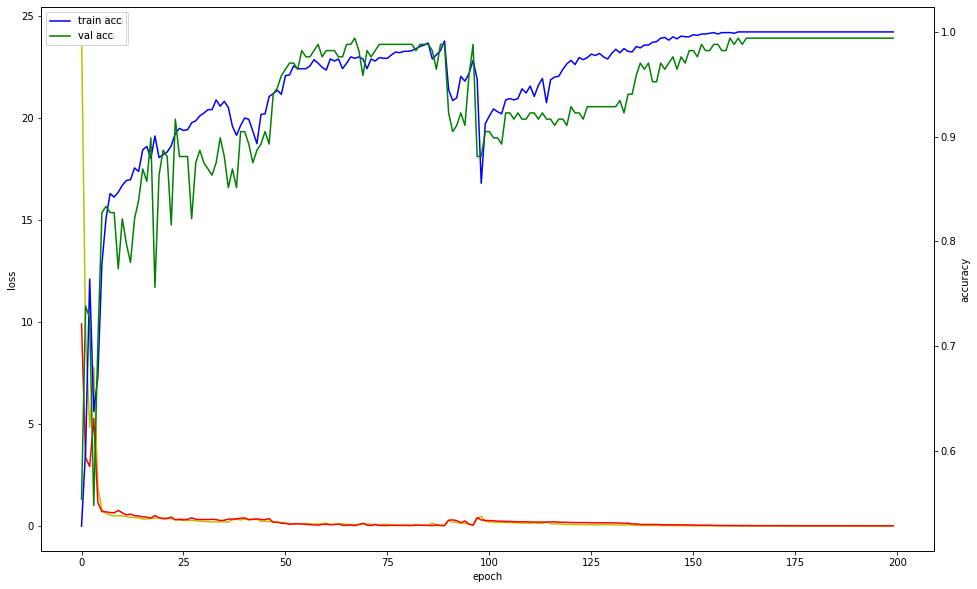

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[85,  0],
        [ 1, 82]],

       [[82,  1],
        [ 0, 85]]], dtype=int64)